In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\tarunraghav
[nltk_data]     srikanth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [49]:
import warnings
warnings.filterwarnings('ignore')

In [50]:
data = pd.read_csv('emails.csv')
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [51]:
data.shape

(5728, 2)

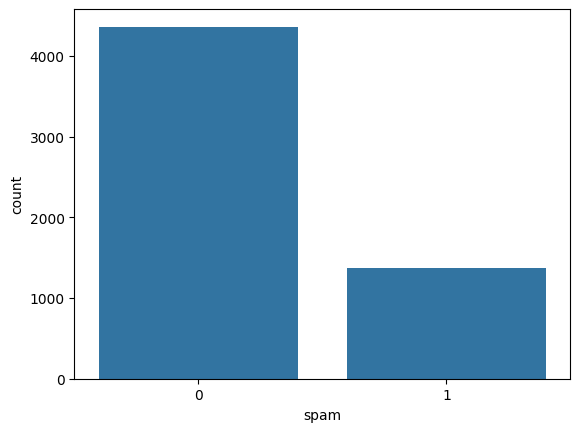

In [52]:
sns.countplot(x='spam', data=data)
plt.show()

In [53]:
# Downsample the dataset

ham = data[data.spam == 0]
spam = data[data.spam == 1]
ham = ham.sample(n=len(spam), random_state=42)

In [54]:
bds = pd.concat([ham, spam])
bds

,text,spam
1547,Subject: interview schedule for jinbaek kim i...,0
2730,"Subject: re : wednesday meeting eric , i thi...",0
4843,Subject: re : london research group i ' d do ...,0
2856,"Subject: re : congratulations vince , thanks ...",0
3804,Subject: osman sezgen steve kromer is request...,0
...,...,...
1363,Subject: are you ready to get it ? hello ! v...,1
1364,Subject: would you like a $ 250 gas card ? do...,1
1365,"Subject: immediate reply needed dear sir , i...",1
1366,Subject: wanna see me get fisted ? fist bang...,1


Text(0.5, 0, 'Message types')

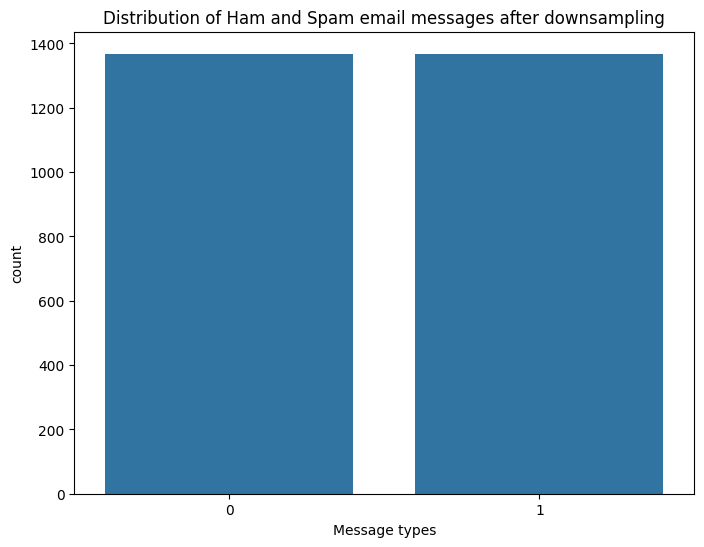

In [55]:
plt.figure(figsize=(8, 6))
sns.countplot(data = bds, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

In [56]:
bds['text']

1547    Subject: interview schedule for jinbaek kim  i...
2730    Subject: re : wednesday meeting  eric ,  i thi...
4843    Subject: re : london research group  i ' d do ...
2856    Subject: re : congratulations  vince , thanks ...
3804    Subject: osman sezgen  steve kromer is request...
                              ...                        
1363    Subject: are you ready to get it ?  hello !  v...
1364    Subject: would you like a $ 250 gas card ?  do...
1365    Subject: immediate reply needed  dear sir ,  i...
1366    Subject: wanna see me get fisted ?  fist  bang...
1367    Subject: hot stock info : drgv announces anoth...
Name: text, Length: 2736, dtype: object

In [57]:
bds['text'] = bds['text'].str.replace('Subject', '')
bds.head()

,text,spam
1547,: interview schedule for jinbaek kim i didn '...,0
2730,": re : wednesday meeting eric , i think we c...",0
4843,: re : london research group i ' d do it as s...,0
2856,": re : congratulations vince , thanks for you...",0
3804,: osman sezgen steve kromer is requesting tha...,0


In [58]:
punclist = string.punctuation
def remove_punc(text):
    temp = str.maketrans('', '', punclist)
    return text.translate(temp)

bds['text'] = bds['text'].apply(lambda x: remove_punc(x))
bds.head()

,text,spam
1547,interview schedule for jinbaek kim i didn t...,0
2730,re wednesday meeting eric i think we can ...,0
4843,re london research group i d do it as soon...,0
2856,re congratulations vince thanks for your n...,0
3804,osman sezgen steve kromer is requesting that...,0


In [63]:
def remove_stopwords(text):
    sw = stopwords.words('english')
    imp = []
    for word in str(text).split():
        word = word.lower()
        if word not in sw:
            imp.append(word)

    output = ' '.join(imp)
    return output

bds['text'] = bds['text'].apply(lambda x: remove_stopwords(x))
bds.head()

,text,spam
1547,interviewschedulejinbaekkimseewenthappymeetjin...,0
2730,wednesdaymeetingericthinkskipmeetingdiscussiss...,0
4843,londonresearchgroupsoonpossiblecallexactlyrega...,0
2856,congratulationsvincethanksnotecongratulationsb...,0
3804,osmansezgenstevekromerrequestingosmanspend1day...,0


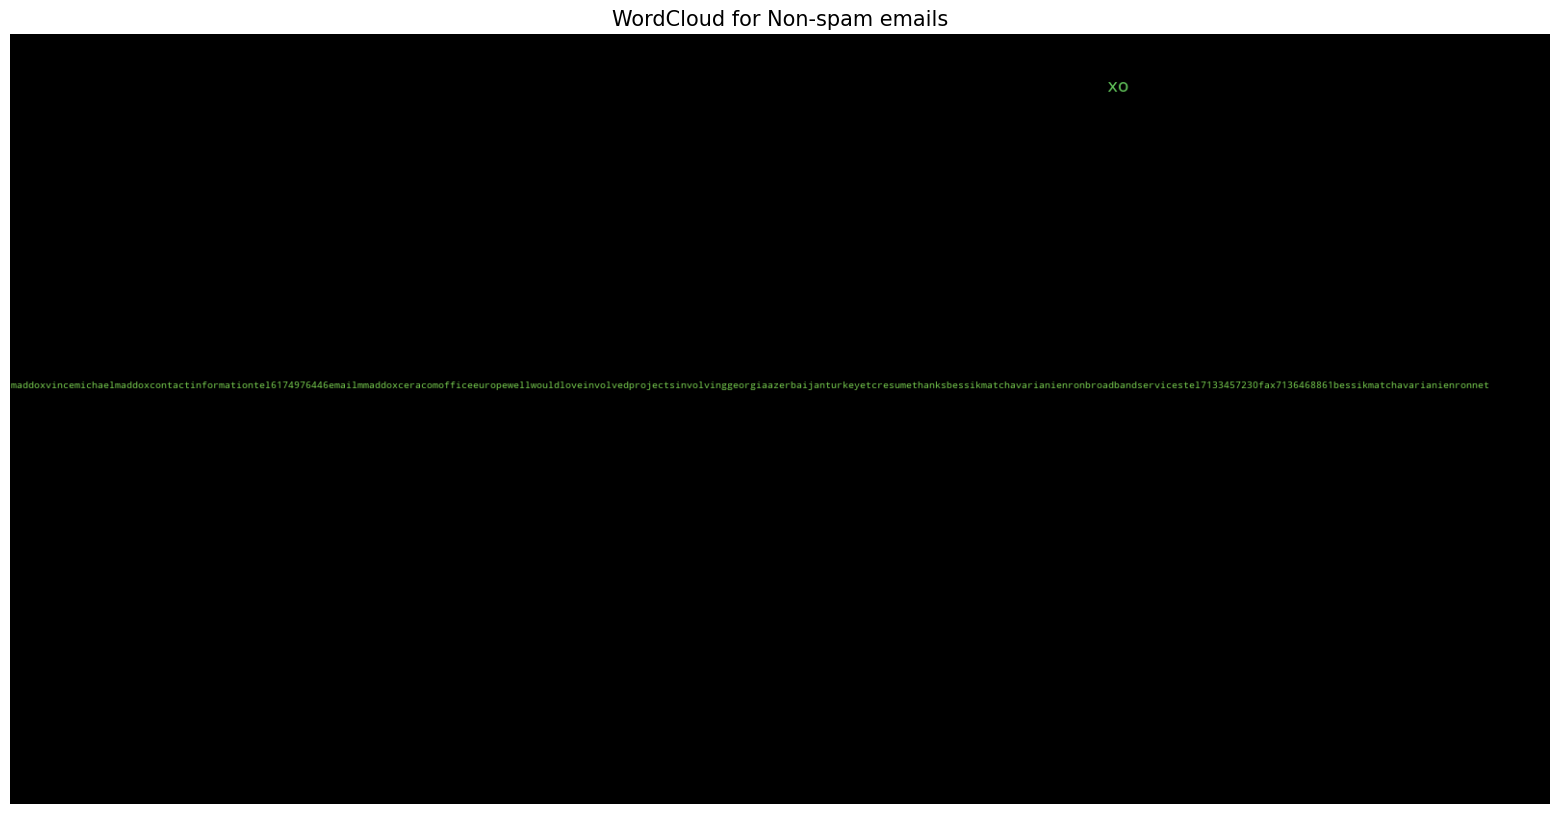

ValueError: Couldn't find space to draw. Either the Canvas size is too small or too much of the image is masked out.

<Figure size 2000x1000 with 0 Axes>

In [66]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    plt.figure(figsize=(20, 10))

    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=1600, height=800,
                   collocations=False).generate(email_corpus)
    
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(bds[bds['spam']==0], typ='Non-spam')
plot_word_cloud(bds[bds['spam']==1], typ='spam')

In [67]:
xtrain, xtest, ytrain, ytest = train_test_split(bds['text'], bds['spam'], test_size=0.2, random_state=42)

In [68]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(xtrain)

In [69]:
trainseq = tokenizer.texts_to_sequences(xtrain)
testseq = tokenizer.texts_to_sequences(xtest)

max_len = 100

trainseq = pad_sequences(trainseq, maxlen=max_len, padding='post', truncating='post')
testseq = pad_sequences(testseq, maxlen=max_len, padding='post', truncating='post')

In [71]:
model = keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1,
                                 output_dim=32, input_length=max_len))

model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [72]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
									output_dim=32, 
									input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [74]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits = True), metrics=['accuracy'], optimizer='adam')

In [86]:
es = EarlyStopping(patience=5,
                   monitor = 'val_accuracy',
                   restore_best_weights = True, verbose=1)

lr = ReduceLROnPlateau(patience = 3,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [88]:
history = model.fit(trainseq, ytrain,
                    validation_data=(testseq, ytest),
                    epochs=20, 
                    batch_size=20,
                    callbacks = [lr]
                   )

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5054 - loss: 0.6931 - val_accuracy: 0.4854 - val_loss: 0.6934
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4867 - loss: 0.6933 - val_accuracy: 0.4854 - val_loss: 0.6934
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4960 - loss: 0.6932 - val_accuracy: 0.4854 - val_loss: 0.6934
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4987 - loss: 0.6932 - val_accuracy: 0.4854 - val_loss: 0.6934
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5047 - loss: 0.6931 - val_accuracy: 0.4854 - val_loss: 0.6934
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5059 - loss: 0.6931 - val_accuracy: 0.4854 - val_loss: 0.6934
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5047 - loss: 0.6931 - val_accuracy: 0.4854 - val_loss: 0.6934
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5069 - loss: 0.6931 - val_accu

In [79]:
test_loss, test_accuracy = model.evaluate(testseq, ytest)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5362 - loss: 0.6928 
Test Loss : 0.6933094263076782
Test Accuracy : 0.485401451587677


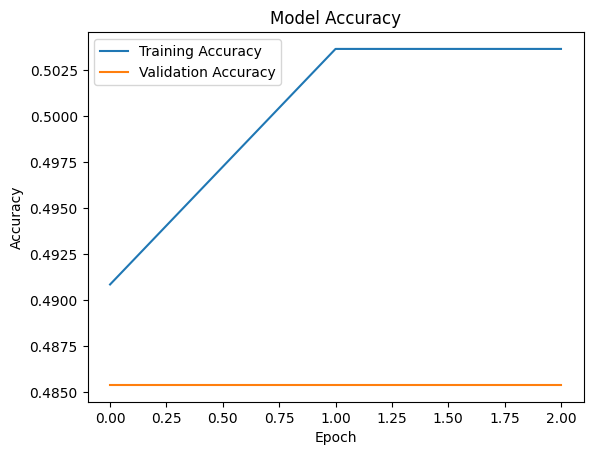

In [83]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
